In [ ]:
!pip install -qU tensorboard_plugin_profile

     |████████████████████████████████| 1.2MB 29.4MB/s 


In [ ]:
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
tf.__version__

'2.5.0'

# 1. Data preparation
## 1.1 Download MNIST dataset


In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = np.concatenate([train_images, test_images])
train_labels = np.concatenate([train_labels, test_labels])
train_images = (train_images - 127.5)/127.5

11493376/11490434 [==============================] - 0s 0us/step


## 1.2 Transform to TF datasets

In [ ]:
from tensorflow.data.experimental import AUTOTUNE

ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
ds = ds.map(lambda img, label: (tf.cast(tf.expand_dims(img,-1), dtype=tf.float32) , label) , num_parallel_calls=AUTOTUNE)
#ds = ds.map(lambda img, label: (img, tf.random.normal(label.shape, stddev=0.2)+label) , num_parallel_calls=AUTOTUNE)
ds = ds.shuffle(70000).batch(256).prefetch(10)
ds

<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>

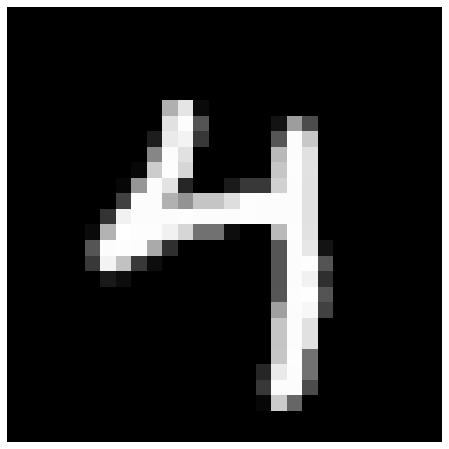

tf.Tensor(4, shape=(), dtype=uint8)


In [ ]:
#sample of input data
img, label = next(iter(ds))
img = tf.squeeze(img[0])
label = label[0]
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
print(label)

# 2. Create the network based on DCGAN


[DCGAN paper link](https://arxiv.org/abs/1511.06434)


## 2.1 Generator
![alt text](https://kharshit.github.io/img/dcgan_generator.png)




In [ ]:
def make_generator_model(noise_dim=100):
  noise = layers.Input(shape=[noise_dim], name='noise')
  condition = layers.Input(shape=[1], name='condition')

  cond_embed = layers.Embedding(10, noise_dim, input_length=1)(condition)
  cond_embed = layers.Flatten()(cond_embed)
  x = layers.Multiply()([noise, cond_embed])  
  x = layers.Dense(7*7*256, activation='relu', use_bias=False)(x)
  x = layers.BatchNormalization()(x) 
  x = layers.Reshape((7, 7, 256))(x)
  x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
  model = Model(inputs=[noise, condition], outputs=[x])
  return model

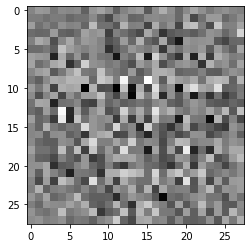

In [ ]:
# test generator
digit_to_generate = 3
generator = make_generator_model()
noise = tf.random.normal([1, 100])
condition = tf.expand_dims(digit_to_generate, 0)
generated_image = generator({'noise':noise, 'condition':condition}, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## 2.2 Discriminator
![alt text](https://kharshit.github.io/img/dcgan_discriminator.png)



In [ ]:
def make_discriminator_model():
  images = layers.Input(shape=[28,28,1], name='images')
  labels = layers.Input(shape=[1], name='labels')
  labels_embed = layers.Embedding(10, 28*28, input_length=1)(labels)
  labels_embed = layers.Reshape([28,28,1])(labels_embed)

  x = layers.Concatenate(axis=-1)([images, labels_embed])
  x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation=layers.LeakyReLU())(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation=layers.LeakyReLU())(x)
  x = layers.BatchNormalization()(x)
  logits = layers.Flatten()(x)

  #c = layers.Dense(50, 'relu')(labels)
  logits = layers.Concatenate()([logits, labels])
  output = layers.Dense(1, activation='sigmoid')(logits)
  model = Model(inputs=[images, labels], outputs=[output])
  return model

In [ ]:
#test discriminator
discriminator = make_discriminator_model()
decision = discriminator({'images':generated_image, 'labels':condition})
print (decision)

tf.Tensor([[0.49298656]], shape=(1, 1), dtype=float32)


## 2.3 Create GAN Model + Training ops

In [ ]:
class GAN(Model):
  def __init__(self, generator, discriminator, latent_dim):
    super(GAN, self).__init__()
    self.generator = generator
    self.discriminator = discriminator
    self.latent_dim = latent_dim
    self.acc = tf.keras.metrics.BinaryAccuracy()

  def compile(self, g_optimizer, d_optimizer, loss_fn):
    super(GAN, self).compile()
    self.g_optimizer = g_optimizer
    self.d_optimizer = d_optimizer
    self.loss_fn = loss_fn

  def discriminator_loss(self, real_output, fake_output):
    real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
    fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
    total_loss = (real_loss + fake_loss)/2
    return total_loss

  def generator_loss(self, fake_output):
    return self.loss_fn(tf.ones_like(fake_output), fake_output)

  def train_step(self, examples):
    images, labels = examples
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      fake_images = self.generator({'noise':noise, 'condition':labels}, training=True)
      real_output = self.discriminator({'images':images, 'labels':labels}, training=True)
      fake_output = self.discriminator({'images':fake_images, 'labels':labels}, training=True)
      gen_loss = self.generator_loss(fake_output)
      disc_loss = self.discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

    self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
    self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
    predictions = tf.concat([real_output, fake_output], axis=0)
    fake_real_labels = tf.concat([tf.ones_like(real_output), tf.zeros_like(fake_output)], axis=0)
    return {'g_loss':gen_loss, 'd_loss':disc_loss, 'acc':self.acc(fake_real_labels, predictions)}

## 2.4. Prepare model

In [ ]:
#initialize the model
gan = GAN(generator=generator, discriminator=discriminator, latent_dim=100)

gan.compile(g_optimizer=tf.keras.optimizers.Adam(1e-4), 
            d_optimizer=tf.keras.optimizers.Adam(1e-4), 
            loss_fn=tf.losses.BinaryCrossentropy(label_smoothing=0.05))
            #loss_fn=tf.losses.CategoricalCrossentropy())

In [ ]:
#location to save logs
logdir = 'logs/'
!rm -r $logdir

rm: cannot remove 'logs/': No such file or directory


In [ ]:
#write generated images on tensorboard
file_writer = tf.summary.create_file_writer(logdir)
def img_writer(epoch, logs,  imgs_to_show=8):
  random_label = tf.random.uniform([imgs_to_show], maxval=10, dtype=tf.int32)
  imgs = generator({'noise':tf.random.normal([imgs_to_show,100]), 
                    'condition':random_label})
  with file_writer.as_default():
    tf.summary.image("Generated data", imgs, step=epoch, max_outputs=imgs_to_show)

    
img_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch,logs: img_writer(epoch,logs))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Load the tensorboard
%load_ext tensorboard

In [ ]:
%tensorboard --logdir $logdir

############################################
###Check the Images tab in tensorboard!!!###
############################################

# 3. Train the model

In [ ]:
gan.fit(ds, epochs=200, callbacks=[img_callback, tensorboard_callback])

# 4. Check the results

In [ ]:
imgs_per_row = 10
#conditions = tf.reshape(tf.tile(tf.expand_dims(tf.range(0, 10), -1), [1,imgs_per_row]),-1)
conditions = tf.reshape(tf.tile(tf.expand_dims(tf.range(0, 10), -1), [1,imgs_per_row]),-1)
noise = tf.random.normal([tf.math.reduce_prod(conditions.shape), 100])
generated_images = generator({'noise':noise, 'condition':conditions}, training=False)
fig = plt.figure(figsize=(10,10))

for i in range(generated_images.shape[0]):
    plt.subplot(10, imgs_per_row, i+1)
    plt.imshow(generated_images[i, :, :, 0] , cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

def generate(condition, n_gen_imgs=5):
  condition = tf.tile(tf.expand_dims([condition], axis=0), [n_gen_imgs,1])
  noise = tf.random.normal([n_gen_imgs, 100])
  generated_images = generator({'noise':noise, 'condition':condition}, training=False)

  for i in range(n_gen_imgs):
    plt.subplot(1, n_gen_imgs, i+1)
    plt.imshow(generated_images[i, :, :, 0] , cmap='gray')
    plt.axis('off')
   
widgets.interact(generate, condition=(0, 9, 1), n_gen_imgs=(1, 10, 1));


In [ ]:
import shutil
shutil.make_archive('zzz', 'zip', logdir)